In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import MobileNetV2
import os

In [26]:
IMG_SIZE = 256 
BATCH_SIZE = 32
CHANNELS = 3

In [27]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "E:\Plant Leaf Disease Prediction\Dataset\subset(96%)",
    labels = 'inferred',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
)

Found 4925 files belonging to 13 classes.


In [28]:
classes = data.class_names

In [29]:
len(data)

154

In [30]:
for img_batch, label_batch in data.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[ 8 12  6  9  4  9  0  7  6  6  8  5  5  7  4  0  6  1  7  8  7  8  6  7
 11  6  7 12  4 10  1 11]


In [31]:
for img_batch, label_batch in data.take(1):
    print(img_batch[0].shape)

(256, 256, 3)


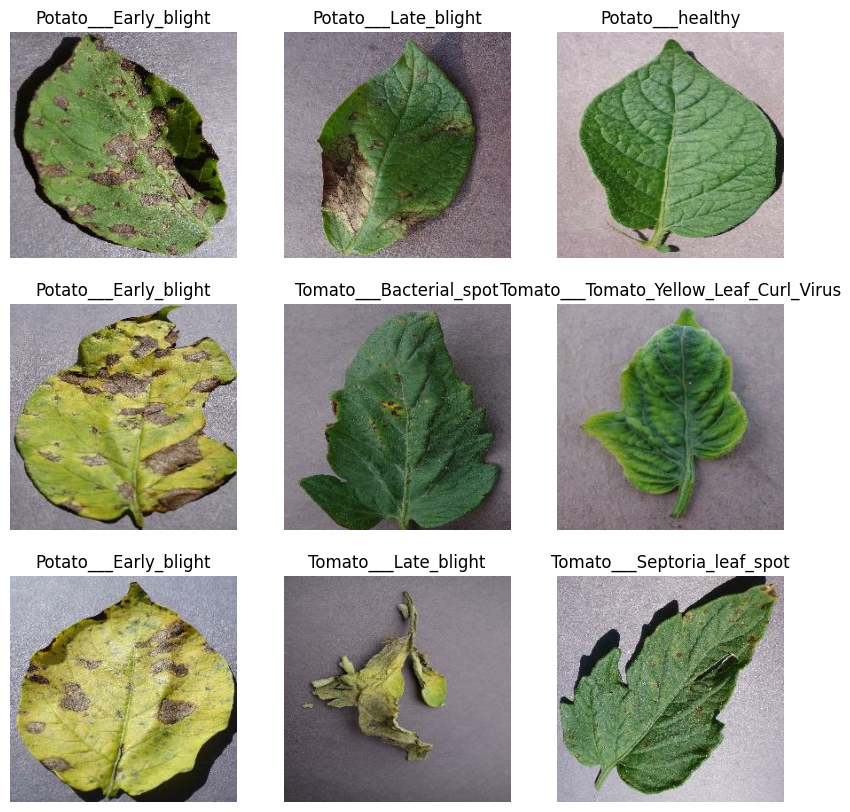

In [32]:
plt.figure(figsize=(10, 10))
for img_batch, label_batch in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img_batch[i].numpy().astype('int'))
        plt.title(classes[label_batch[i].numpy()])
        plt.axis('off')

In [33]:
def prepare_datasets(data, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=2000):
    size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size)

    train_size = int(size*train_split)
    val_size = int(size*val_split)

    train_data = data.take(train_size)
    rem_data = data.skip(train_size)
    val_data = rem_data.take(val_size)
    test_data = rem_data.skip(val_size)

    return train_data, val_data, test_data

In [34]:
train_data, val_data, test_data = prepare_datasets(data)

In [35]:
print(len(train_data), len(val_data), len(test_data))
print(len(data))

123 15 16
154


In [36]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
preprocess_image = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
        tf.keras.layers.Rescaling(1./255)
    ]
)

In [38]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2)
    ]
)

In [39]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = 13

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers in the base model
base_model.trainable = False

model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy >= self.target_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% training accuracy, stopping training.")
            self.model.stop_training = True

stop_training_callback = StopTrainingAtAccuracy(target_accuracy=0.90)

In [42]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
    verbose=1,
    epochs=25,
    callbacks=[stop_training_callback]
)

Epoch 1/25
123/123 [==============================] - 111s 801ms/step - loss: 2.4545 - accuracy: 0.1571 - val_loss: 1.9969 - val_accuracy: 0.4354
Epoch 2/25
123/123 [==============================] - 81s 661ms/step - loss: 1.8482 - accuracy: 0.3994 - val_loss: 1.3070 - val_accuracy: 0.6667
Epoch 3/25
123/123 [==============================] - 98s 798ms/step - loss: 1.3904 - accuracy: 0.5495 - val_loss: 1.0378 - val_accuracy: 0.6750
Epoch 4/25
123/123 [==============================] - 86s 698ms/step - loss: 1.1628 - accuracy: 0.6288 - val_loss: 0.7543 - val_accuracy: 0.7771
Epoch 5/25
123/123 [==============================] - 84s 681ms/step - loss: 0.9663 - accuracy: 0.6824 - val_loss: 0.6745 - val_accuracy: 0.8146
Epoch 6/25
123/123 [==============================] - 85s 693ms/step - loss: 0.8383 - accuracy: 0.7312 - val_loss: 0.5259 - val_accuracy: 0.8500
Epoch 7/25
123/123 [==============================] - 138s 1s/step - loss: 0.7462 - accuracy: 0.7615 - val_loss: 0.5066 - val_acc

In [43]:
model.evaluate(test_data)

16/16 [==============================] - 19s 619ms/step - loss: 0.3116 - accuracy: 0.8965


[0.31163305044174194, 0.896484375]

Actual label:  Potato___Early_blight
1/1 [==============================] - 2s 2s/step
Predicted label:  Potato___Early_blight


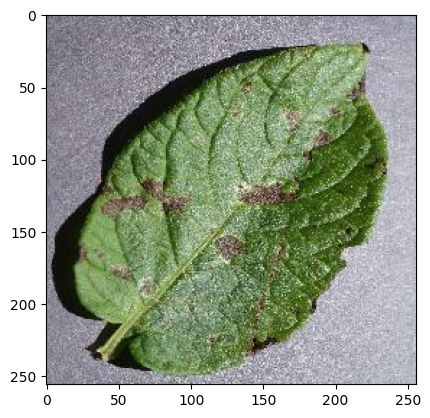

In [44]:
for img_batch, label_batch in test_data.take(1):
    first_image = img_batch[0].numpy().astype('int')
    first_label = label_batch[0].numpy()
    print("Actual label: ", classes[first_label])
    pred = model.predict(img_batch)
    print("Predicted label: ", classes[np.argmax(pred[0])])
    plt.imshow(first_image)

1/1 [==============================] - 0s 102ms/step


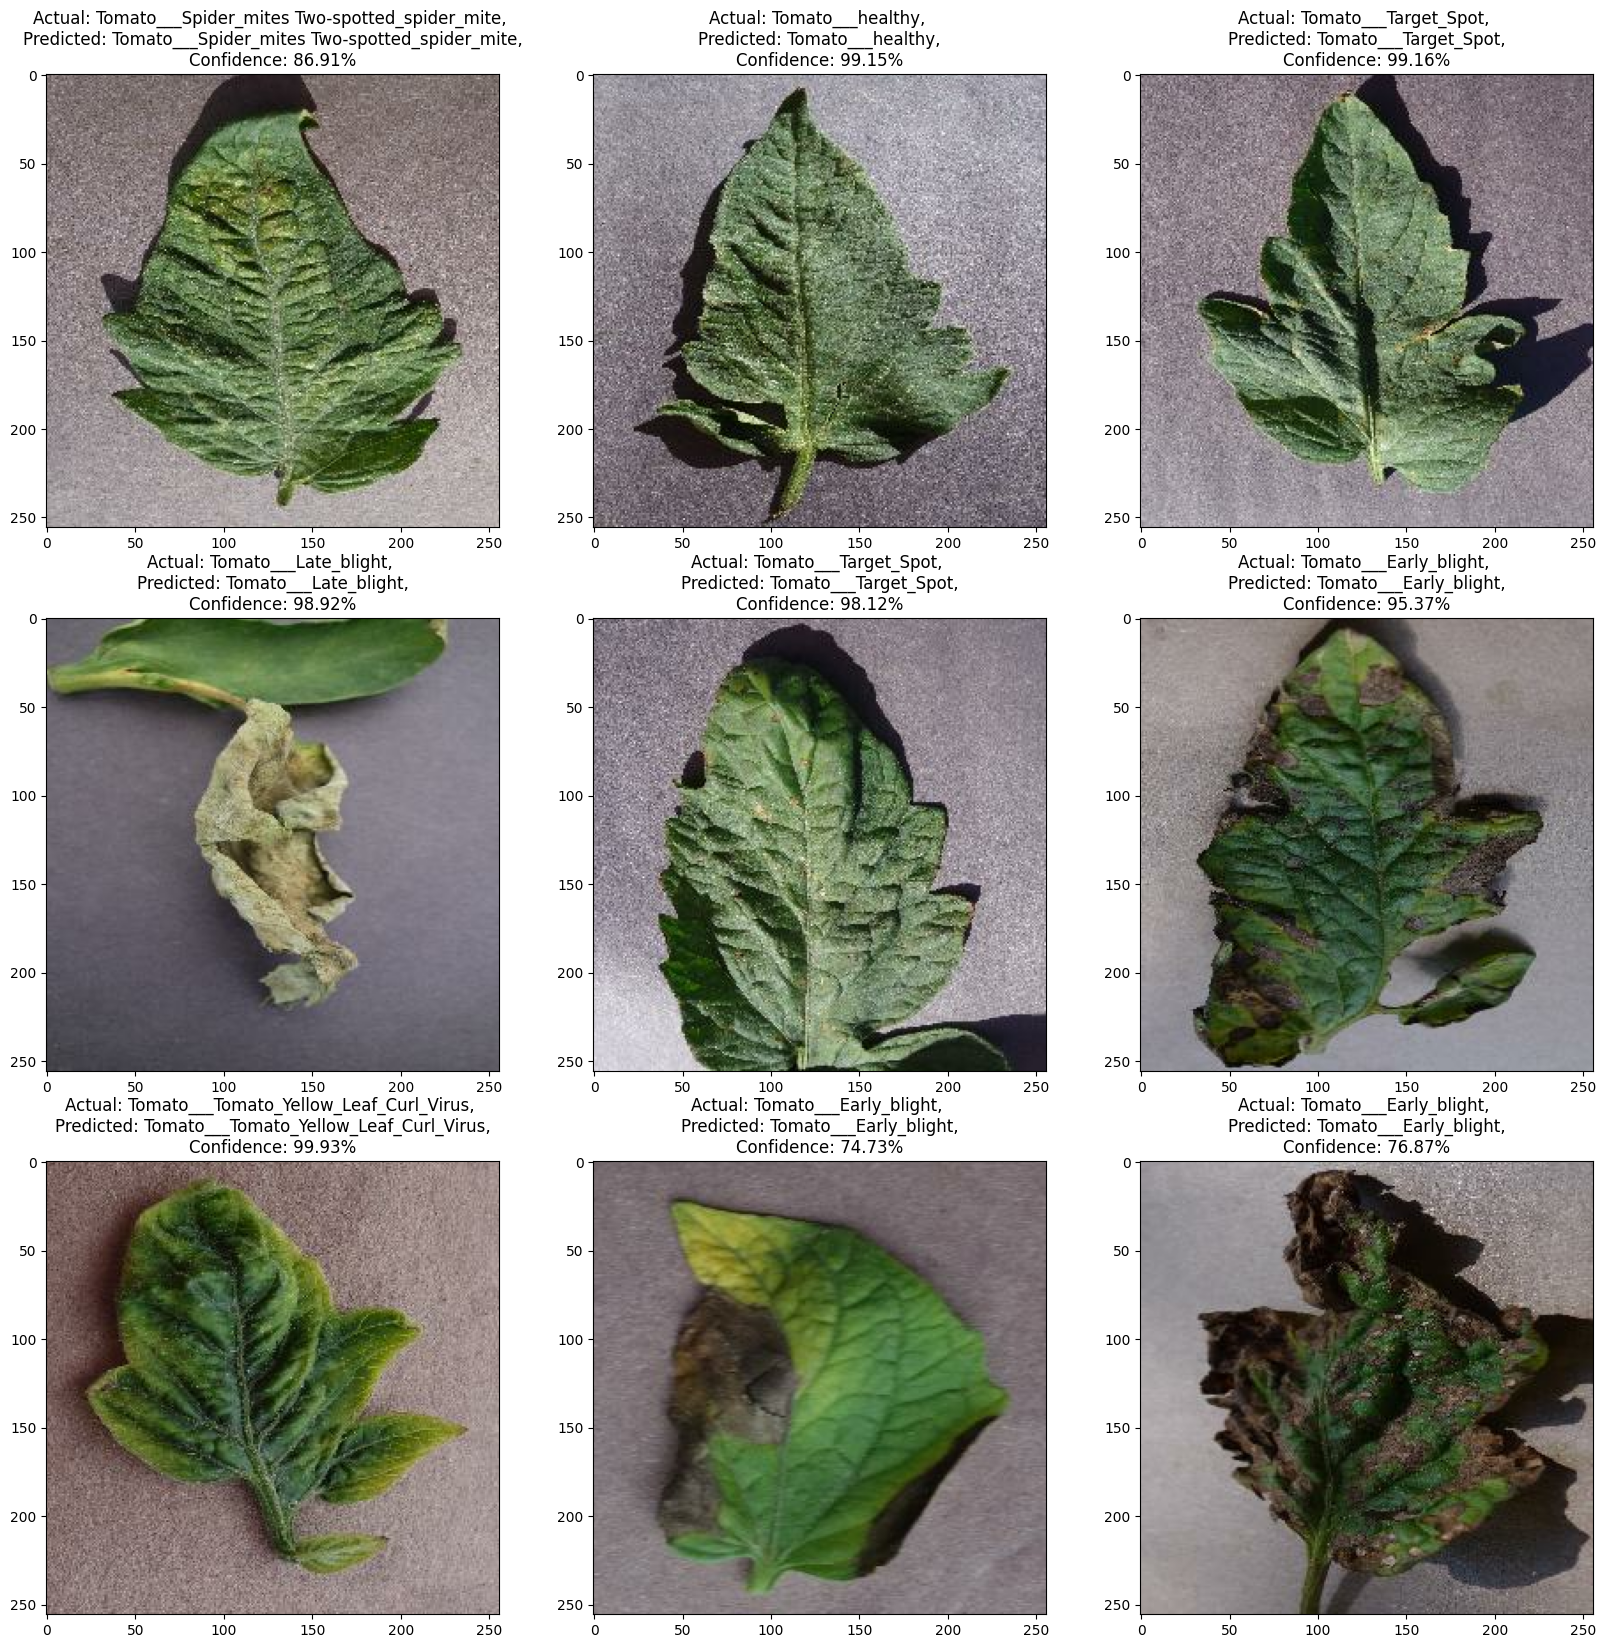

In [45]:
def predict(model, img):
    img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), axis=0)
    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100*np.max(predictions[0]), 2)
    return predicted_class, confidence

plt.figure(figsize=(20, 20))
for img_batch, label_batch in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img_batch[i].numpy().astype('int'))
        predicted_class, confidence = predict(model, img_batch[i])
        actual_class = classes[label_batch[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\nConfidence: {confidence}%")

In [46]:
model_version = 1
os.makedirs("E:/Plant Leaf Disease Prediction (GitHub)/Plant-Leaf-Disease-Prediction/models", exist_ok=True)
model.save(f"E:/Plant Leaf Disease Prediction (GitHub)/Plant-Leaf-Disease-Prediction/models/model_v{model_version}.h5")